# GAN - Generative Adversarial Networks
### GAN składa się z 2 głównych elementów
- Generatowa: sieci trenowanej w celu tworzenia obrazów
- Discriminatora: sieć trenowana w celu rozpoznawania czy obraz jest prawdziwy czy fałszywy

![picture](https://drive.google.com/uc?id=1nKqrSCWRHb2qOWA7jUuX9_2EVpNdRyRH)

### **Generator** - na wejściu otrzymuje losowy wektor który ma reprezontować cechy obrazu a na wyjściu wygenerowany obraz. Można interpretować działanie generatoria jako odwrotne do tego co robiły CNN które na wejściu dostawały obraz i zwracały feature vector - wektor cech, w tym przypadku jest odwrotnie, otrzymujemy wektor cech i zwracamy obraz. Kolejna analogią jest embedowanie, dostajemy zdania które zamieniamy na wektory.

### **Descriminator** - na wejście dostaje obraz wygenerowany przez generator oraz prawdziwe zdjęcia i ma określić które które są prawdziwe a które nie.

![picture](https://drive.google.com/uc?id=1Cut-qs_KFjlPBK0c39TpAegGgsEhuycm)
































































### Wektor cech możemy przedstawić w ten sposób, wektor [9, 0] może reprezentować obrazy których wygląd jest zbliżony do 2 a wektor [1, 8] bardziej przypomina liczbę 9. **Generator** otrzymuje własnie taki wektor (o różnej liczbie wymiarów) i zwraca obraz (taki jak pokazany po prawej stronie)
![picture](https://drive.google.com/uc?id=1BU5a9i-pvF90IdaYFs0HMqjU26SbzZ0V)



































### Porównanie działania CNN zamieniającego obraz na feature vector i generate jako części GAN zamieniającej feature vector na obraz.

![picture](https://drive.google.com/uc?id=1pYW_7HbQxPmIbj0OraUo8iW3xwIErBOR)


























### Podczas uczenia GAN nie ma co patrzeć na loss i accuracy ponieważ nie zachowują sie one tak jak powinny, sieci nazwajem uczą sie naśladowac więc nie będziemy widzieli ładnych wykresów jak przy ANN czy CNN. Żaden z modeli nie może mieć zbyt duże skuteczności ponieważ znaczyłoby to że przykładowo obrazy są generowane tak dobrze przez generator że, discriminator nie jest wstanie ich rozróżnić i przez to dalej się uczyć.
![picture](https://drive.google.com/uc?id=174EzLd6lGzJkk_MXH_pkKzcmTaCYsUwc)






































### Podsumowanie:

![picture](https://drive.google.com/uc?id=1dzICvJodFN2d928XlAAVvfOkSrRdepvL)




# Implementacja GAN

In [2]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


# Load in the data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Map imputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape: ", x_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape:  (60000, 28, 28)


In [3]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)


In [4]:
# Dimensionality of the latent space
latent_dim = 100

In [5]:
# Get genarator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [6]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model


In [7]:
# Compile both models preparation for training

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# Pass noise through generator to get an image
img = generator(z)

# Make sure only the generator is trained
discriminator.trainable = False

# The true output is fake
fake_pred = discriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)

# Compile th ecombined model
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)



In [20]:
# Train the GAN

# Config
batch_size = 32
epochs = 5100 # było 30000 ale za długo trwa
sample_period = 200 # every sample_period steps generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generate images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')


In [21]:
# A function to the generate a grid of random samples from the generator
# and save them to file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" %epoch)
  plt.close()



In [22]:
# Main training loop
for epoch in range(epochs):
  # Train dicriminator

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)


  # Train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1} / {epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
epoch: 201 / 5100, d_loss: 0.64, d_acc: 0.53, g_loss: 0.72
1/1 [==============================] - 0s 24ms/step
epoch: 301 / 5100, d_loss: 0.61, d_acc: 0.61, g_loss: 0.76
1/1 [==============================] - 0s 26ms/step
epoch: 401 / 5100, d_loss: 0.62, d_acc: 0.67, g_loss: 0.78
1/1 [==============================] - 0s 41ms/step
epoch: 501 / 5100, d_loss: 0.62, d_acc: 0.64, g_loss: 0.89
1/1 [==============================] - 0s 30ms/step
epoch: 601 / 5100, d_loss: 0.63, d_acc: 0.61, g_loss: 0.83
1/1 [==============================] - 0s 25ms/step
epoch: 701 / 5100, d_loss: 0.59, d_acc: 0.69, g_loss: 0.94
1/1 [==============================] - 0s 23ms/step
epoch: 801 / 5100, d_loss: 0.63, d_acc: 0.56, g_loss: 0.90
1/1 [==============================] - 0s 23ms/step
epoch: 901 / 5100, d_loss: 0.52, d_acc: 0.81, g_loss: 0.97
1/1 [==============================] - 0s 29ms/step
epoch: 10

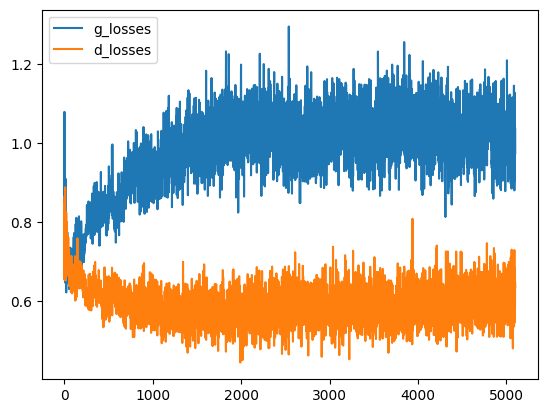

In [23]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

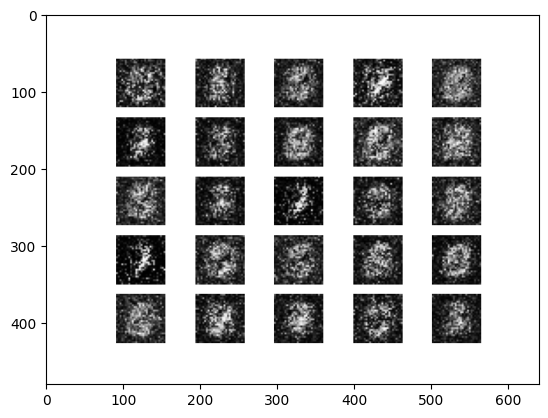

In [26]:
# po lepsze efekty trzeba zwiększyć liczbe epoch do np. 30000
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

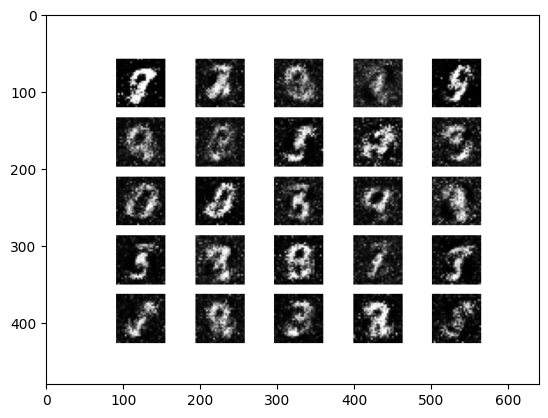

In [27]:
a = imread('gan_images/1000.png')
plt.imshow(a)

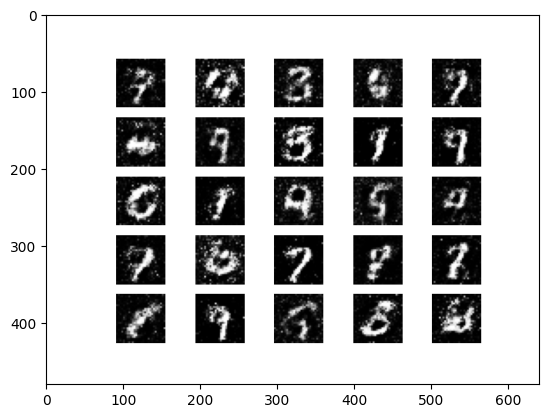

In [31]:
a = imread('gan_images/2600.png')
plt.imshow(a)

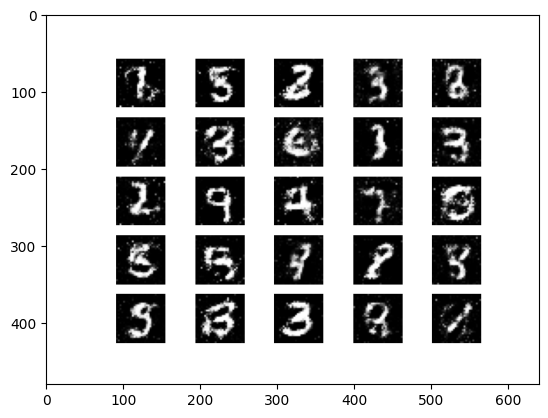

In [29]:
a = imread('gan_images/5000.png')
plt.imshow(a)